In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F

**Define Fixed point Utility functions and Fixed ViT Transformer Model**

In [2]:

# Fixed-point utility functions
def fixed_point_quantize(tensor, scale):
    """Quantize tensor to fixed-point representation."""
    return torch.round(tensor * scale).clamp(-2**15, 2**15 - 1) / scale

class FixedPointMLP(nn.Module):
    """Fixed-point implementation of a feedforward layer."""
    def __init__(self, input_dim, hidden_dim, output_dim, scale):
        super(FixedPointMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
        self.scale = scale

    def forward(self, x):
        x = fixed_point_quantize(self.fc1(x), self.scale)
        x = F.relu(x)
        x = fixed_point_quantize(self.fc2(x), self.scale)
        return x

class FixedPointAttention(nn.Module):
    """Fixed-point implementation of a self-attention mechanism."""
    def __init__(self, embed_dim, num_heads, scale):
        super(FixedPointAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = scale
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=True)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=True)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        qkv = fixed_point_quantize(self.qkv(x), self.scale)
        q, k, v = qkv.chunk(3, dim=-1)
        q = q.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (k.size(-1) ** 0.5)
        scores = fixed_point_quantize(F.softmax(scores, dim=-1), self.scale)
        context = torch.matmul(scores, v)
        context = context.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)

        return fixed_point_quantize(self.out_proj(context), self.scale)

class FixedPointTransformerEncoderLayer(nn.Module):
    """A single encoder layer in a Fixed Vision Transformer."""
    def __init__(self, embed_dim, num_heads, hidden_dim, scale):
        super(FixedPointTransformerEncoderLayer, self).__init__()
        self.self_attn = FixedPointAttention(embed_dim, num_heads, scale)
        self.mlp = FixedPointMLP(embed_dim, hidden_dim, embed_dim, scale)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.scale = scale

    def forward(self, x):
        # Self-attention
        attn_output = fixed_point_quantize(self.self_attn(self.norm1(x)), self.scale)
        x = fixed_point_quantize(x + attn_output, self.scale)

        # Feedforward
        mlp_output = fixed_point_quantize(self.mlp(self.norm2(x)), self.scale)
        x = fixed_point_quantize(x + mlp_output, self.scale)

        return x

class FixedPointViT(nn.Module):
    """Vision Transformer with fixed-point arithmetic."""
    def __init__(self, image_size, patch_size, num_classes, embed_dim, depth, num_heads, hidden_dim, scale):
        super(FixedPointViT, self).__init__()
        self.scale = scale

        # Patch embedding
        self.patch_size = patch_size
        # number of patches
        self.patch_dim = (image_size // patch_size) ** 2
        self.embedding = nn.Linear(3 * patch_size * patch_size, embed_dim)

        # Positional embeddings
        self.positional_embedding = nn.Parameter(torch.zeros(1, self.patch_dim, embed_dim))

        # Transformer encoder
        self.layers = nn.ModuleList([
            FixedPointTransformerEncoderLayer(embed_dim, num_heads, hidden_dim, scale)
            for _ in range(depth)
        ])

        # Classification head
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # Extract patches and flatten them
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, -1, 3 * self.patch_size * self.patch_size)

        # Embed the patches
        x = fixed_point_quantize(self.embedding(patches), self.scale)

        # Add positional embeddings
        x = fixed_point_quantize(x + self.positional_embedding, self.scale)

        # Transformer encoder
        for layer in self.layers:
            x = layer(x)

        # Classification head (global average pooling)
        x = x.mean(dim=1)
        return self.classifier(x)

**Define Hyperparameters**

In [3]:
# Hyperparameters
batch_size = 64
epochs = 200
learning_rate = 0.001
image_size = 32
patch_size = 4
embed_dim = 512
depth = 3
num_heads = 16
hidden_dim = 256
scale = 2**8
target_classes = [0, 1, 2]  # 'airplane', 'automobile', 'bird'

**Load Dataset**

In [4]:

# Load CIFAR-10 dataset and filter classes
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
# ])

transform = transforms.Compose([transforms.RandomCrop(size=32),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                                  std=[0.2471, 0.2435, 0.2616]),
                                              ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                                  std=[0.2471, 0.2435, 0.2616]),
                                              ])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Filter the dataset to include only classes [0, 1, 2]
train_indices = [i for i, label in enumerate(train_set.targets) if label in target_classes]
test_indices = [i for i, label in enumerate(test_set.targets) if label in target_classes]

# Subset the data for training and testing
train_subset = Subset(train_set, train_indices)
test_subset = Subset(test_set, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,pin_memory=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False,pin_memory=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Model Initialization**

In [5]:

# Define the model
model = FixedPointViT(image_size, patch_size, len(target_classes), embed_dim, depth, num_heads, hidden_dim, scale).cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracy, loss,average gradient norms and growth epochs for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
growth_epochs = []
avg_grad_norms = []

# GROW thresholds
grad_clip_threshold = 0.3
grad_threshold = 0.3
loss_threshold = 0.95
grow_every_n_epochs = 20

#Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=0.001
)

In [6]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/My Drive/ECE498NSG/models/GRADViT.pt'

load_model = 0

if (load_model == 1):
  checkpoint = torch.load('/content/drive/My Drive/ECE498NSG/models/GRADViT.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  train_losses = checkpoint['train_losses']
  train_accuracies = checkpoint['train_accuracies']
  val_accuracies = checkpoint['val_accuracies']
  growth_epochs = checkpoint['growth_epochs']
  avg_grad_norms = checkpoint['avg_grad_norms']


Mounted at /content/drive


**Define Training , Model Growth Criteria and Validation**

In [7]:
# Training loop
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    gradient_norms = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))
        gradient_norms.append(grad_norm.item())

        # Gradient clipping (if needed)
        if grad_norm > grad_clip_threshold:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_threshold)

        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Track average gradient norm for the epoch
    avg_grad_norm = sum(gradient_norms) / len(gradient_norms)
    avg_grad_norms.append(avg_grad_norm)

    # Check if the model should grow -> Growth Criterias
    if (epoch > 20 and (epoch % grow_every_n_epochs == 0) and (avg_grad_norm > grad_threshold or epoch_loss > loss_threshold)):  # Loss threshold
        print(f"Model growth triggered at epoch {epoch + 1}")
        growth_epochs.append(epoch + 1)
        # Grow the model
        new_layer = FixedPointTransformerEncoderLayer(embed_dim, num_heads, hidden_dim, scale)

        # Move the new layer to the correct device #added to maintain on same device
        new_layer = new_layer.to(next(model.parameters()).device)

        # Initialize new layer with smaller weights
        for param in new_layer.parameters():
                nn.init.normal_(param, mean=0.0, std=0.02)

        # Append the new layer to the model
        model.layers.append(new_layer)

        # Apply weight decay to the optimizer (L2 regularization)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler.step(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Training_Loss: {epoch_loss:.4f}, Training_Accuracy: {epoch_accuracy:.2f}%")

# Validation loop
# def validate(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.cuda(), labels.cuda()
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#     accuracy = 100 * correct / total
#     val_accuracies.append(accuracy)
#     print(f"Validation Accuracy: {accuracy:.2f}%")

def validate(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    # Calculate average loss
    avg_loss = running_loss / total
    val_losses.append(avg_loss)
    print(f"Validation_Loss: {avg_loss:.4f}, Validation_Accuracy: {accuracy:.2f}%")
    return accuracy, avg_loss


**Train and Validation Loop**

In [8]:
# Training and validation loop
for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, epoch)
    validate(model, test_loader, criterion)

Epoch [1/200], Training_Loss: 0.9394, Training_Accuracy: 56.35%
Validation_Loss: 0.8698, Validation_Accuracy: 61.73%
Epoch [2/200], Training_Loss: 0.8608, Training_Accuracy: 61.60%
Validation_Loss: 0.8408, Validation_Accuracy: 64.33%
Epoch [3/200], Training_Loss: 0.8292, Training_Accuracy: 63.74%
Validation_Loss: 0.8186, Validation_Accuracy: 64.27%
Epoch [4/200], Training_Loss: 0.8097, Training_Accuracy: 64.56%
Validation_Loss: 0.8058, Validation_Accuracy: 65.77%
Epoch [5/200], Training_Loss: 0.7949, Training_Accuracy: 65.43%
Validation_Loss: 0.7923, Validation_Accuracy: 65.60%
Epoch [6/200], Training_Loss: 0.7848, Training_Accuracy: 65.77%
Validation_Loss: 0.7817, Validation_Accuracy: 66.83%
Epoch [7/200], Training_Loss: 0.7784, Training_Accuracy: 66.52%
Validation_Loss: 0.7800, Validation_Accuracy: 66.63%
Epoch [8/200], Training_Loss: 0.7696, Training_Accuracy: 67.00%
Validation_Loss: 0.7664, Validation_Accuracy: 67.03%
Epoch [9/200], Training_Loss: 0.7637, Training_Accuracy: 67.11%


In [9]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'growth_epochs': growth_epochs,
    'avg_grad_norms': avg_grad_norms,
}, save_path)


**Plot Matrics -> Training Loss, Training Accuracy, Validation accuracy, Gradient Norms for each epoch**

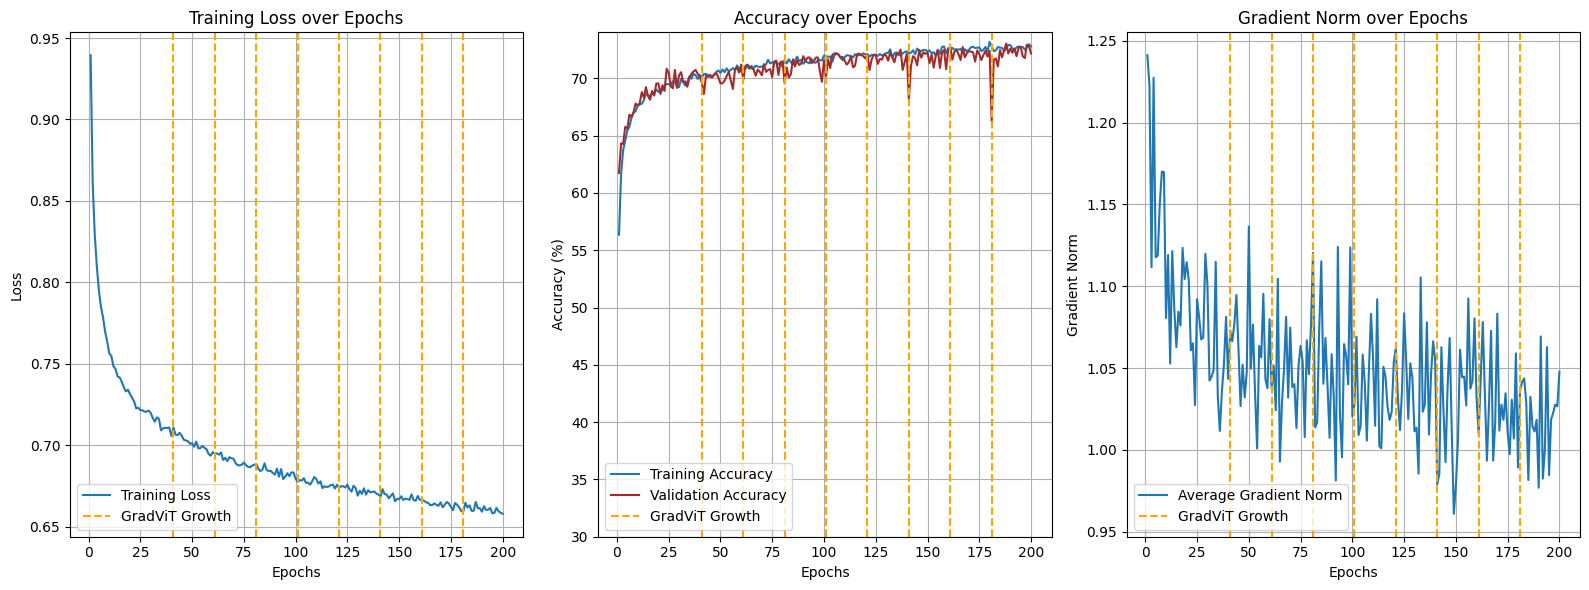

In [10]:
plt.figure(figsize=(16, 6))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()  # Ensure the legend appears

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='brown')
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(bottom=30.0)
plt.legend()  # Combine the legends properly
plt.grid(True)

# Plot Gradient Norms
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), avg_grad_norms, label='Average Gradient Norm')
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Gradient Norm over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.grid(True)
plt.legend()  # Ensure the legend appears

plt.tight_layout()
plt.show()


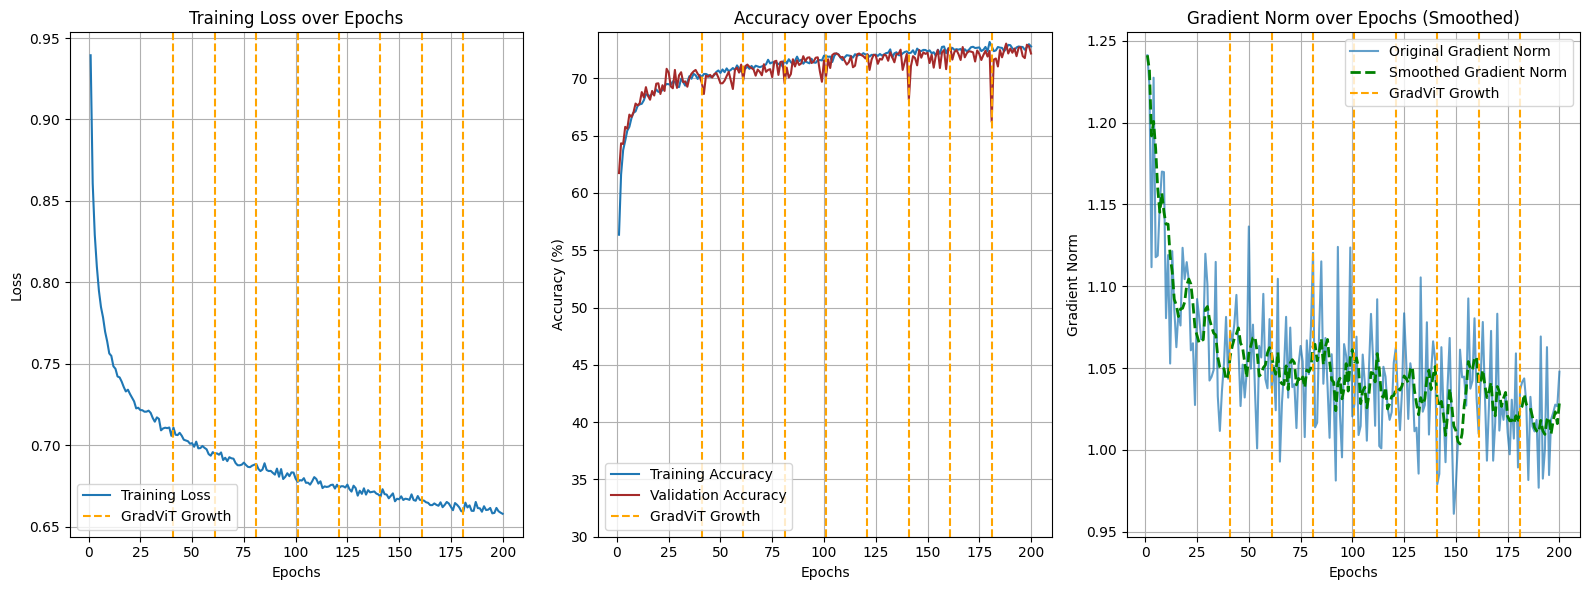

In [11]:

# Function to smooth the gradient norms using a simple moving average
def smooth(data, window_size=5):
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window_size + 1)
        end = i + 1
        smoothed.append(sum(data[start:end]) / (end - start))
    return smoothed

# Apply smoothing to avg_grad_norms
smoothed_grad_norms = smooth(avg_grad_norms, window_size=5)

# Plotting the training/validation accuracy, loss, and gradient norms
plt.figure(figsize=(16, 6))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()  # Ensure the legend appears

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='brown')
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(bottom=30.0)
plt.legend()  # Combine the legends properly
plt.grid(True)

# Plot Gradient Norms (with smoothing)
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs + 1), avg_grad_norms, label='Original Gradient Norm', alpha=0.7)
plt.plot(range(1, epochs + 1), smoothed_grad_norms, label='Smoothed Gradient Norm', color='green', linestyle='--', linewidth=2)
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Gradient Norm over Epochs (Smoothed)')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.grid(True)
plt.legend()  # Ensure the legend appears

plt.tight_layout()
plt.show()


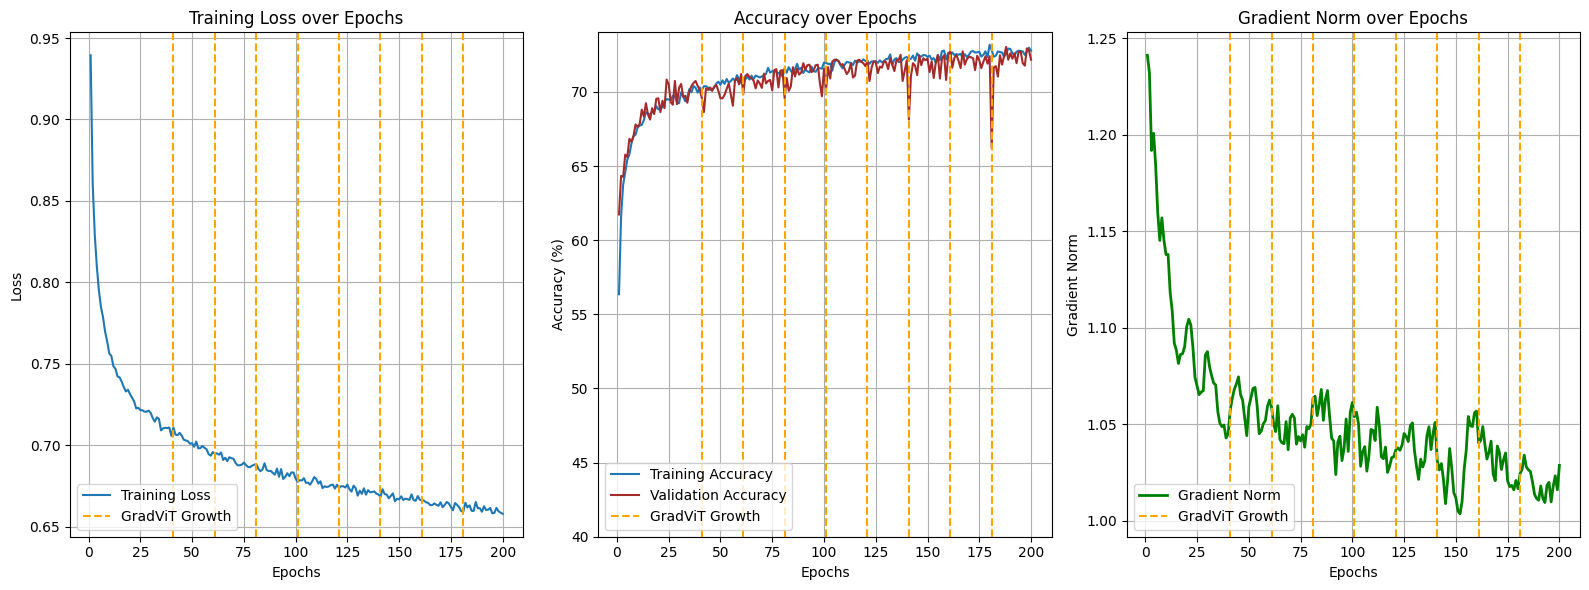

In [15]:

# Function to smooth the gradient norms using a simple moving average
def smooth(data, window_size=5):
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window_size + 1)
        end = i + 1
        smoothed.append(sum(data[start:end]) / (end - start))
    return smoothed

# Apply smoothing to avg_grad_norms
smoothed_grad_norms = smooth(avg_grad_norms, window_size=5)

# Plotting the training/validation accuracy, loss, and gradient norms
plt.figure(figsize=(16, 6))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()  # Ensure the legend appears

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='brown')
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(bottom=40.0)
plt.legend()  # Combine the legends properly
plt.grid(True)

# Plot Gradient Norms (with smoothing)
plt.subplot(1, 3, 3)
#plt.plot(range(1, epochs + 1), avg_grad_norms, label='Original Gradient Norm', alpha=0.7)
plt.plot(range(1, epochs + 1), smoothed_grad_norms, label='Gradient Norm', color='green', linewidth=2)
# Mark growth epochs
for i, growth_epoch in enumerate(growth_epochs):
    plt.axvline(x=growth_epoch, color='orange', linestyle='--', label='GradViT Growth' if i == 0 else None)
plt.title('Gradient Norm over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.grid(True)
plt.legend()  # Ensure the legend appears

plt.tight_layout()
plt.show()


**Inference From Standard architectures against GradViT and comparing performances on CIFAR-10**

| **Metric**              | **Fixed-Point Arithmetic**                                                                 | **Floating-Point Arithmetic**                                                               | **Dynamic Fixed-Point (GradViT)**                                                                 |
|--------------------------|-------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|
| **Accuracy**            | - Limited dynamic range and precision.<br>- Prone to quantization errors.<br>- Suitable for simpler models or low-variance data.  | - High dynamic range and precision.<br>- Ideal for numerical stability.<br>- Handles small gradients and large-scale data effectively. | - Improves accuracy by adapting precision based on input gradients.<br>- Reduces errors compared to static fixed-point but slightly less precise than floating-point. |
| **Computation Speed**   | - Faster due to simpler hardware requirements (e.g., adders, shifters).<br>- Suitable for real-time processing.                  | - Slower on edge devices due to normalization logic.<br>- Optimized for high-end GPUs/TPUs but still slower than fixed-point.          | - Fast, as adaptiveness prioritizes critical computations.<br>- Slower than static fixed-point but faster than floating-point in most cases. |
| **Memory Consumption**  | - Very low due to smaller bit-width (e.g., 8-bit or 16-bit).<br>- Suited for memory-constrained systems.                        | - High memory usage due to larger bit-width (e.g., 32-bit or 64-bit).<br>- Scales poorly for memory-limited systems.                 | - Low memory usage with dynamic allocation of bit-width.<br>- Slight overhead for storing adaptiveness metadata.                           |
| **Energy Efficiency**   | - Highly energy-efficient due to simple operations.<br>- Suitable for low-power environments.                                   | - Energy-intensive due to complex hardware logic and high bit-width operations.<br>- Poor choice for energy-constrained systems.     | - Energy-efficient by reducing redundant computations.<br>- Slightly higher consumption than static fixed-point for adaptation logic.      |
| **Numerical Stability** | - Poor stability for small gradients or very large/small numbers.<br>- Requires careful scaling for sensitive applications.      | - Excellent stability due to wide range and high precision.<br>- Ideal for training or inference with diverse data scales.           | - Improved stability over fixed-point by allocating resources dynamically based on gradient importance.<br>- May still struggle with extreme gradients. |
| **Hardware Complexity** | - Simple hardware (adders, multipliers, and shifters).<br>- Low design and implementation overhead.                            | - Complex hardware with floating-point units (FPUs).<br>- Requires specialized support on certain devices.                         | - Moderate complexity due to adaptiveness logic.<br>- Balances the simplicity of fixed-point with adaptive decision-making circuits.        |
| **Scaling Requirements**| - Requires careful manual scaling for dynamic range adjustments.<br>- Susceptible to scaling errors.                           | - Automatically handles scaling through normalization logic.                                                                       | - Reduces scaling issues by dynamically adapting representation, though still less automated than floating-point.                          |
| **Deployment Use Case** | - Ideal for low-cost, low-power, and real-time systems like IoT devices<br>, wearables, and basic edge AI systems.                  | - Best for high-performance applications like cloud AI, scientific computing, <br> and training large neural networks.                   | - Optimized for edge devices requiring both energy efficiency and acceptable precision.<br>- Great for vision tasks in low-power setups.   |
